<a href="https://colab.research.google.com/github/ayush-kumar-rai/A.N.D.-Intern/blob/Credit-Card-Fraud-Detection/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed as a genuine transaction, which is detrimental.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use(style='ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
#Loading & Inspecting Data
data = pd.read_csv('/content/card_transdata.csv')
# Show the first 5 rows
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
# Getting information about each variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714822 entries, 0 to 714821
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              714822 non-null  float64
 1   distance_from_last_transaction  714822 non-null  float64
 2   ratio_to_median_purchase_price  714821 non-null  float64
 3   repeat_retailer                 714821 non-null  float64
 4   used_chip                       714821 non-null  float64
 5   used_pin_number                 714821 non-null  float64
 6   online_order                    714821 non-null  float64
 7   fraud                           714821 non-null  float64
dtypes: float64(8)
memory usage: 43.6 MB


In [4]:
# number of columns
print(f'# columns: {data.shape[1]}')

# number of rows
print(f'# rows: {data.shape[0]}')

# columns: 8
# rows: 714822


## Data Cleansing

In [5]:
## Check the sum of missing values for each column
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    1
repeat_retailer                   1
used_chip                         1
used_pin_number                   1
online_order                      1
fraud                             1
dtype: int64

In [6]:
# Check the sum of duplicate rows
print(f'# duplicate rows: {data.duplicated().sum()}')

# duplicate rows: 0


In [7]:
# Creating a descriptive statistics table for data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,714822.0,26.645728,64.951608,0.004874,3.878550,9.969968,25.777567,10632.723672
distance_from_last_transaction,714822.0,5.024645,26.412341,0.000118,0.296046,0.997517,3.351701,11851.104565
ratio_to_median_purchase_price,714821.0,1.825076,2.802792,0.004399,0.475436,0.997862,2.098321,267.802942
repeat_retailer,714821.0,0.881449,0.323260,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,714821.0,0.350169,0.477023,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,714821.0,0.100901,0.301198,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,714821.0,0.650483,0.476818,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,714821.0,0.087509,0.282579,0.000000,0.000000,0.000000,0.000000,1.000000


## Data Correlation


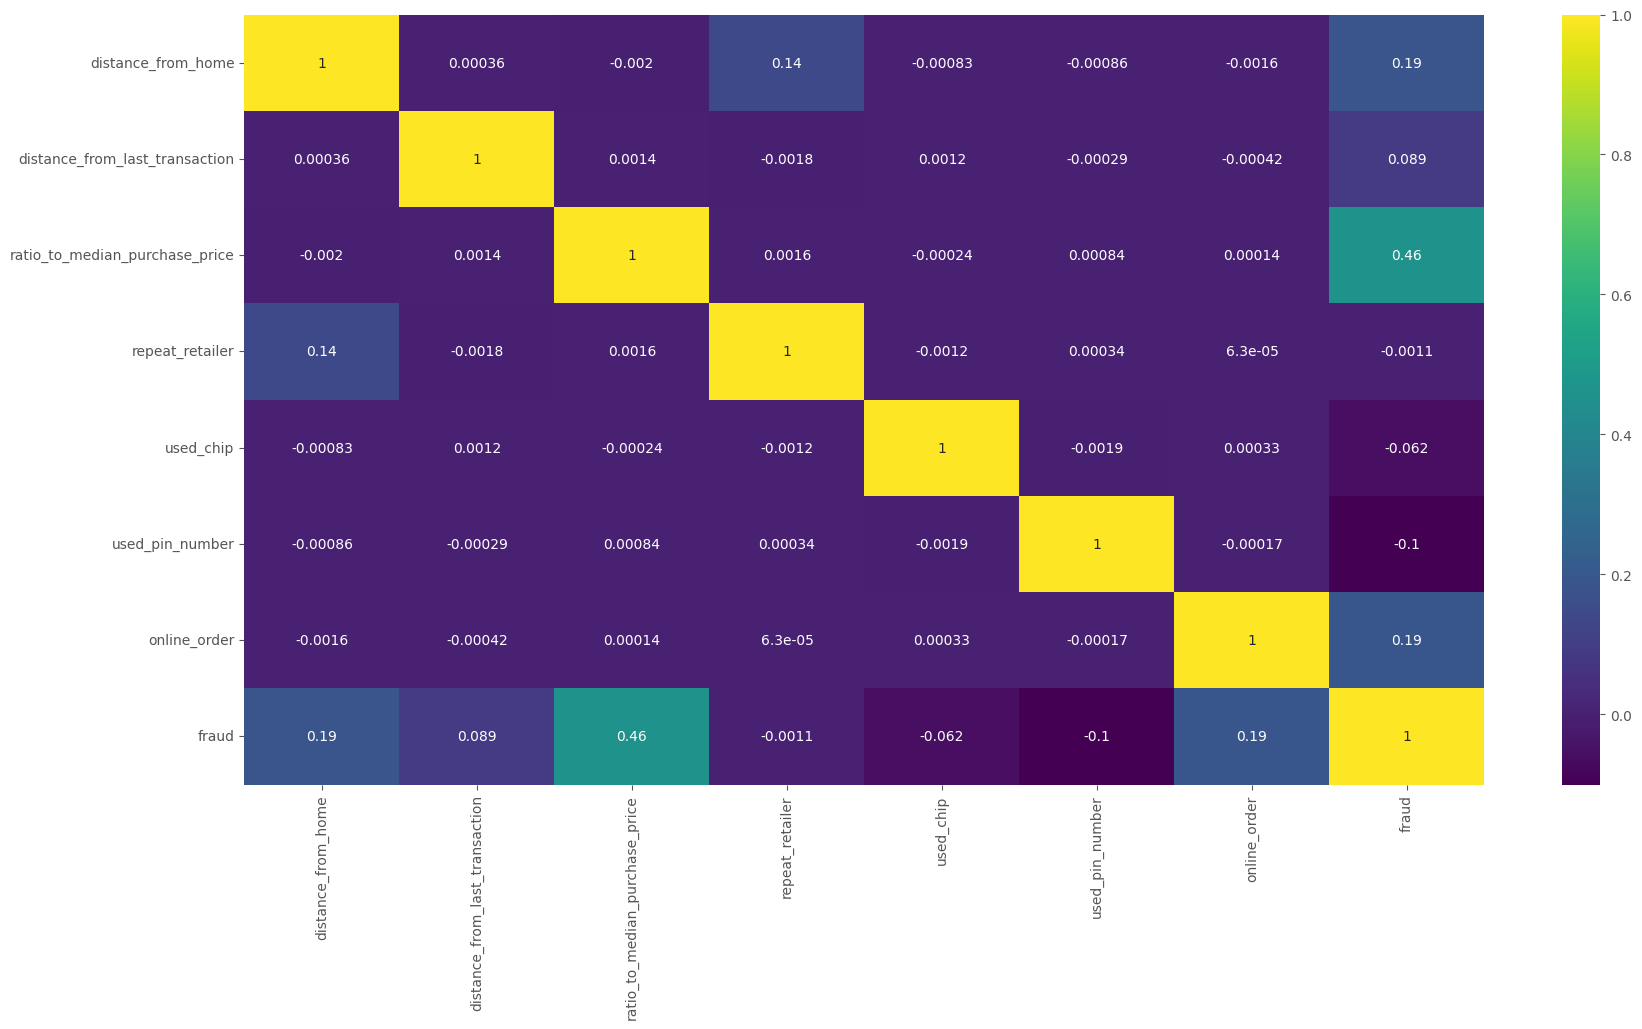

In [8]:
# Heatmap to explain the correlation between the features
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr(), annot = True, cmap='viridis')
plt.show()

In [9]:
# Correlations with fraud
corr = data.corr()['fraud'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")

,fraud
fraud,1.000000
ratio_to_median_purchase_price,0.462135
online_order,0.192416
distance_from_home,0.187705
distance_from_last_transaction,0.088707
repeat_retailer,-0.001137
used_chip,-0.061804
used_pin_number,-0.100603


## Exploratory Data Analysis (EDA)

In [10]:
#Univariate Analysis
#a. Target Feature (Fraud)
data['fraud'].value_counts()

0.0    652268
1.0     62553
Name: fraud, dtype: int64

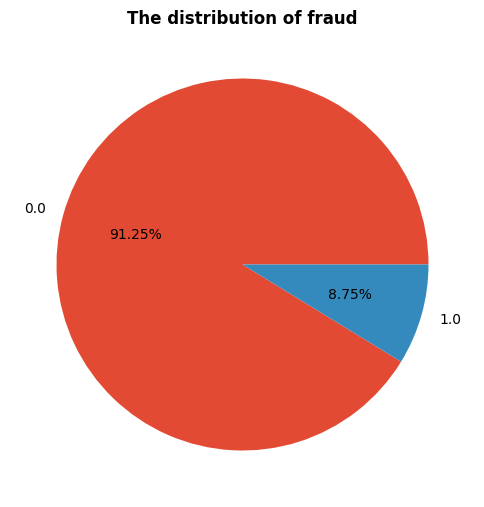

In [11]:
plt.figure(figsize = (6, 8))
plt.pie(x = data['fraud'].value_counts().values,
        labels = data['fraud'].value_counts().index,
        autopct = '%1.2f%%')
plt.title('The distribution of fraud', size = 12, weight = 'bold')
plt.show()

### Observation:

We have 91.26% of Genuine transactions (912,597) and only 8.74% (87,403) of fraud transactions!

Because the data in the fraud variable is imbalanced, it's better consider to taking advantage of undersampling or oversampling techniques to solve this problem.


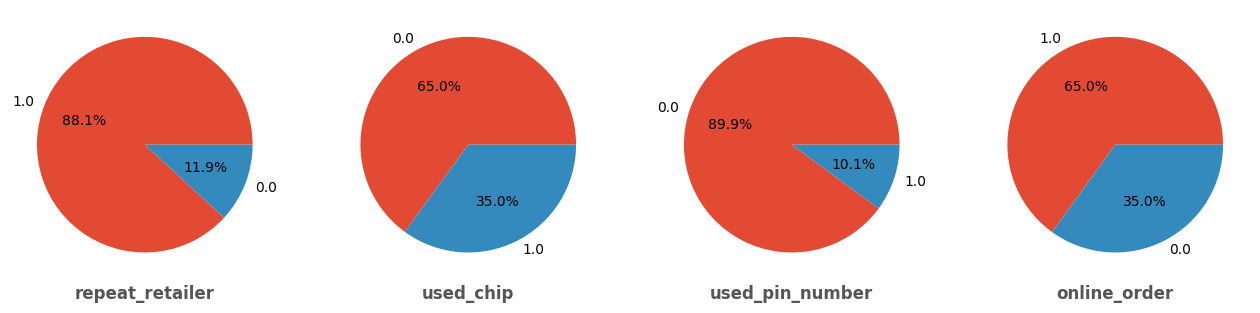

In [12]:
#Categorical Features

# Create a list containing categorical features
cat_features = ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']

# Drawing a pie plot to display the distribution of each categorical column
plt.figure(figsize = (16, 12))
for i, col in enumerate(cat_features):
    plt.subplot(1, 4, i+1)
    plt.pie(x = data[col].value_counts().values,
            labels = data[col].value_counts().index,
            autopct = '%1.1f%%')
    plt.xlabel(col, weight = 'bold')
plt.show()

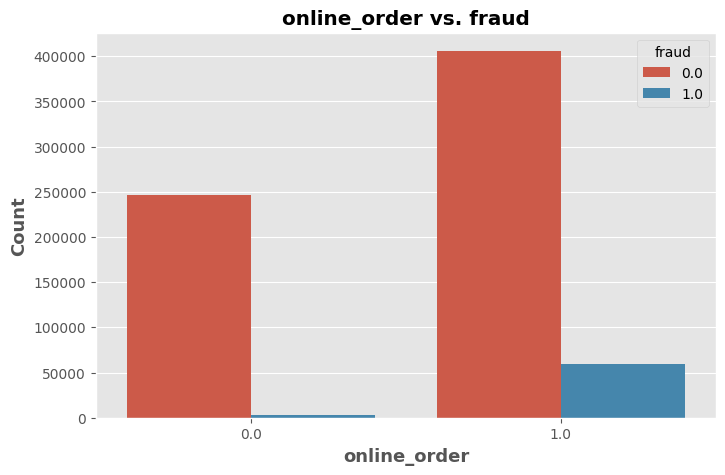

In [13]:
#Bi-variate Analysis

#b. What is the impact of online and offline orders on fraud?
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'online_order',
              hue = 'fraud')


# Adding labels and title
plt.title('online_order vs. fraud', weight = 'bold')
plt.xlabel('online_order', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

### Observations:

Fraud is more common in cases of online orders.

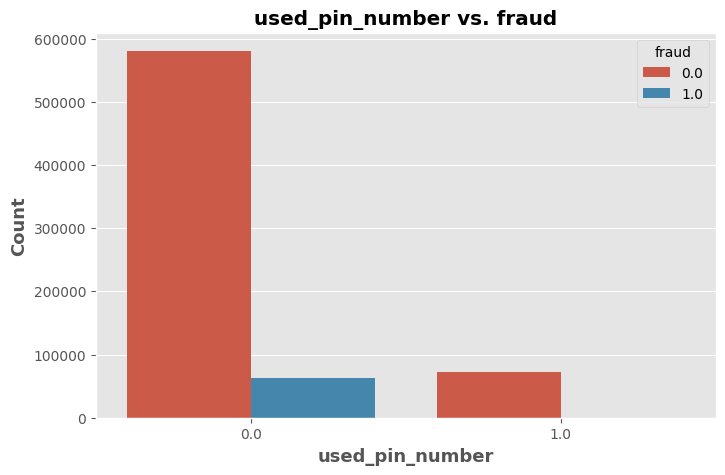

In [14]:
#c. What is the impact of using PIN on fraud?
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'used_pin_number',
              hue = 'fraud')


# Add labels and title
plt.title('used_pin_number vs. fraud', weight = 'bold')
plt.xlabel('used_pin_number', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

### Observation:

Fraud is more common in cases where do not use PIN.

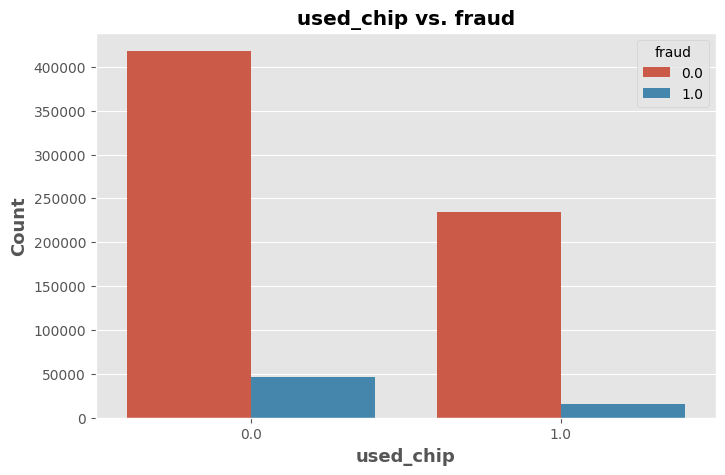

In [15]:
#d. What is the impact of using credit cards on fraud?
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'used_chip',
              hue = 'fraud')


# Adding labels and title
plt.title('used_chip vs. fraud', weight = 'bold')
plt.xlabel('used_chip', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

### Observation:

Fraud is more common in cases where do not use credit cards.

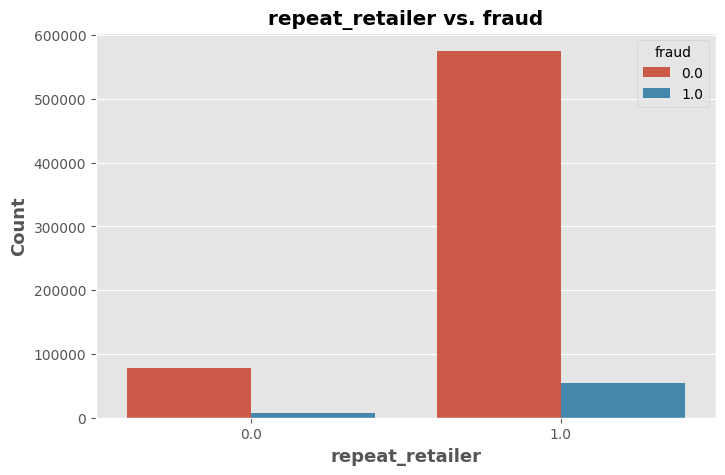

In [16]:
#e. What is the impact of transactions from the same retailer on fraud?
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'repeat_retailer',
              hue = 'fraud')


# Add labels and title
plt.title('repeat_retailer vs. fraud', weight = 'bold')
plt.xlabel('repeat_retailer', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

### Observation:

Fraud is more common in cases of transactions from the same retailer.

# Data Pre-processing

In [17]:
print(f' The number of samples before removing outliers: {data.shape[0]}')

 The number of samples before removing outliers: 714822


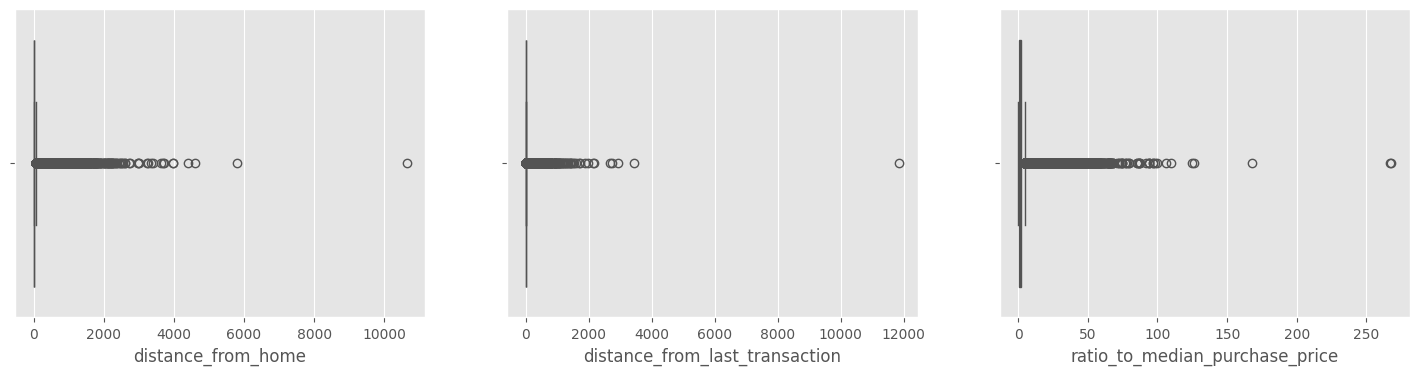

In [18]:
# Create a list containing numerical features
num_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
# Drawing a boxplot to display the distribution of each numerical column to detect the outliers
plt.figure(figsize = (18, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = data, x = col)
plt.show()

In [19]:
# Remove outliers
def remove_outliers(df, col):

    # 1st quartile (25%)
    Q1 = df[col].quantile(0.25)
    # 3rd quartile (75%)
    Q3 = df[col].quantile(0.75)

    # Interquartile range (IQR)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df
data_no_outliers = data.copy()
for col in num_features:
    data_no_outliers = remove_outliers(data_no_outliers, col)


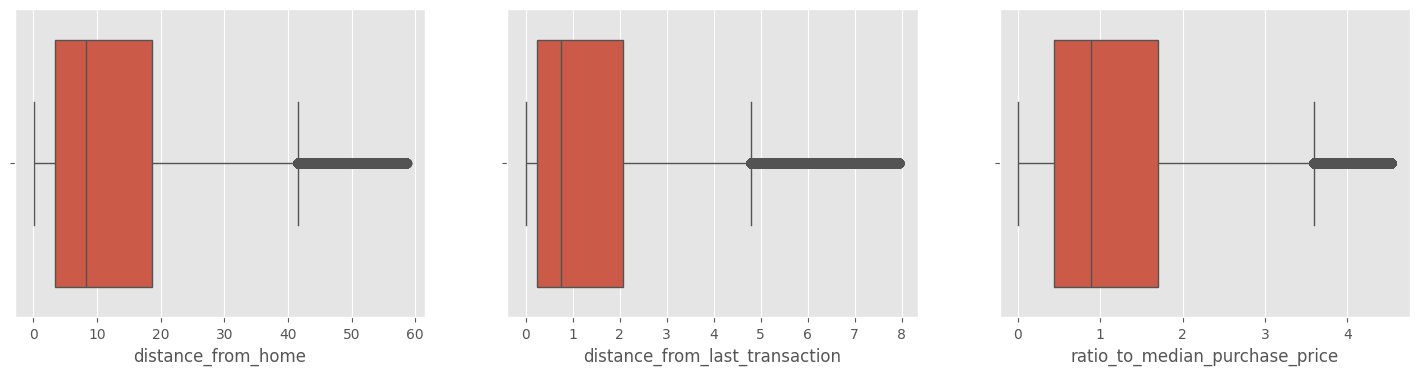

In [20]:
# Drawing a boxplot to display the distribution of each numerical column after removing the outliers
plt.figure(figsize = (18, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = data_no_outliers, x = col)
plt.show()

In [21]:
print(f' The number of samples after removing outliers: {data_no_outliers.shape[0]}')

 The number of samples after removing outliers: 513602


## Splitting Data

In [22]:
# Splitting data to X (Features) and y (label)
X = data_no_outliers.drop('fraud', axis = 1)
y = data_no_outliers['fraud']

# Splitting data to X_train, y_train, X_test, and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)
print('X training shape = ', X_train.shape)
print('Y training shape = ', y_train.shape)
print('X test shape     = ', X_test.shape)
print('Y test shape     = ', y_test.shape)

X training shape =  (359521, 7)
Y training shape =  (359521,)
X test shape     =  (154081, 7)
Y test shape     =  (154081,)


## Data Normalization (Scaling)

In [23]:
# rescaling the numerical features using StandardScaler
scaler = StandardScaler()

# Fit the data
scaler.fit(X_train)

StandardScaler()

In [24]:
# Transform the X train
X_train = scaler.transform(X_train)

# Transform the X test data
X_test = scaler.transform(X_test)

### Imbalanced Data
SMOTE (Synthetic Minority Oversampling Technique) synthesizes elements for the minority class. SMOTE works by selecting examples that are close to the feature space, drawing a line between the examples in the feature space, and drawing a new sample at a point along that line.

In [25]:
# SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority', random_state = 42)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)
# Count of each unique value in y_train
y_train.value_counts()

0.0    354944
1.0      4577
Name: fraud, dtype: int64

In [26]:
# Count of each unique value in y_train after using SMOTE
y_train_os.value_counts()

0.0    354944
1.0    354944
Name: fraud, dtype: int64

## Modeling

In [33]:
def cross_validation_score(estimator_name, estimator, X_train, y_train, score = 'recall', n = 5):

    '''This function is to validate the model across multiple stratified splits'''


    # Create a StratifiedKFold object with number of folds
    folds = StratifiedKFold(n_splits = n, shuffle = True, random_state = 42)

    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = folds)

    print(f'Cross Validation Scores of {estimator_name}: {validate} \n')
    print(f'Mean of Scores for {estimator_name}: {validate.mean()} \n')
    print(f'Standard Deviation of Scores for {estimator_name}: {validate.std()}')
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'recall', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''


    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               cv = n,
                               scoring = score )

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator
def model_evaluation(model, X_test, y_test, color = 'Reds'):

    ''' This function is used to evaluate the model through on classification report  and confusion matrix'''


    # classification report
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0), '\n ')

    #confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), cmap = color, annot = True)
    plt.xlabel('Predicted', size = 12, weight = 'bold')
    plt.ylabel('Actual', size = 12, weight = 'bold')
    plt.title('Confusion Matrix', weight = 'bold')
    plt.show()
def roc_auc_curve_score(model, X_test, y_test):

    '''This function plots the roc-auc curve and calculate the model ROC-AUC score '''

    # y predicted value
    #y_pred = model.predict(X_test)

    # y predicted probability
    y_proba = model.predict_proba(X_test)

    # ROC_AUC Score
    score = roc_auc_score(y_test, y_proba[:, 1])

    # ROC Curve
    fpr ,tpr ,thresholds = roc_curve(y_test, y_proba[:, 1])

    plt.figure(figsize = (8, 5))
    plt.plot(fpr, tpr, label = 'ROC_AUC Score (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc = "lower right")
    plt.show()

## Logistic Regression

In [34]:
# Instantiating Logistic Regression Classifier
log_reg = LogisticRegression()

# Fit the data
log_reg.fit(X_train_os, y_train_os)

LogisticRegression()

In [35]:
# Training Accurecy
log_reg.score(X_train_os, y_train_os)

0.9969220496754417

In [37]:
#cross_validation_score
cross_validation_score('Logistic Regression', log_reg, X_train_os, y_train_os)

Cross Validation Scores of Logistic Regression: [1. 1. 1. 1. 1.] 

Mean of Scores for Logistic Regression: 1.0 

Standard Deviation of Scores for Logistic Regression: 0.0


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    152119
         1.0       0.68      1.00      0.81      1962

    accuracy                           0.99    154081
   macro avg       0.84      1.00      0.90    154081
weighted avg       1.00      0.99      0.99    154081
 
 


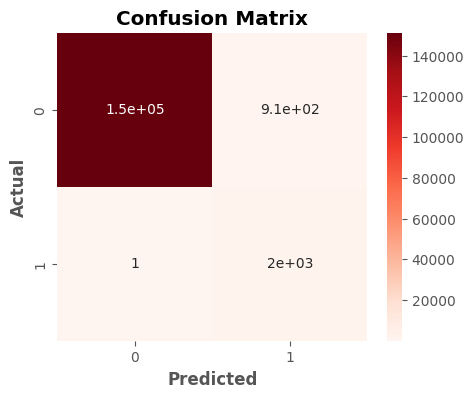

In [38]:
#Model Evaluation
model_evaluation(log_reg, X_test, y_test)

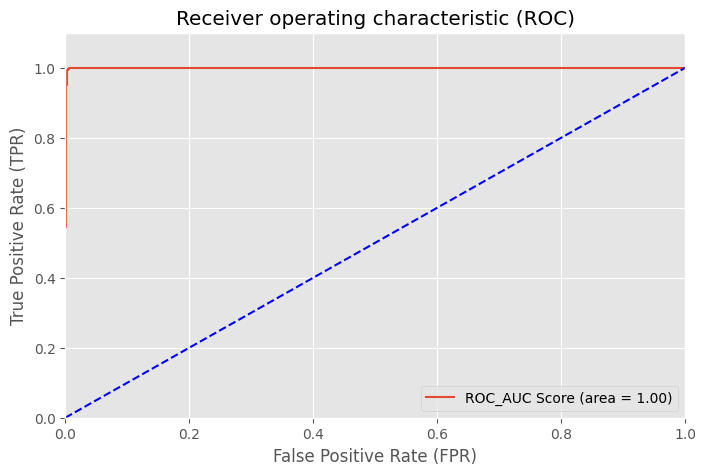

In [39]:
roc_auc_curve_score(log_reg, X_test, y_test)

## Decision Tree

In [40]:
# Instantiating Decision Tree Classifier
d_tree = DecisionTreeClassifier()

# Fit the data
d_tree.fit(X_train_os, y_train_os)

DecisionTreeClassifier()

In [41]:
# Training Accurecy
d_tree.score(X_train_os, y_train_os)

1.0

In [42]:
#Cross Validation
cross_validation_score('Decision Tree', d_tree, X_train_os, y_train_os, n = 10)

Cross Validation Scores of Decision Tree: [1.         1.         1.         0.99997183 1.         0.99997183
 1.         1.         1.         1.        ] 

Mean of Scores for Decision Tree: 0.9999943653242042 

Standard Deviation of Scores for Decision Tree: 1.1269351593300322e-05


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    152119
         1.0       1.00      1.00      1.00      1962

    accuracy                           1.00    154081
   macro avg       1.00      1.00      1.00    154081
weighted avg       1.00      1.00      1.00    154081
 
 


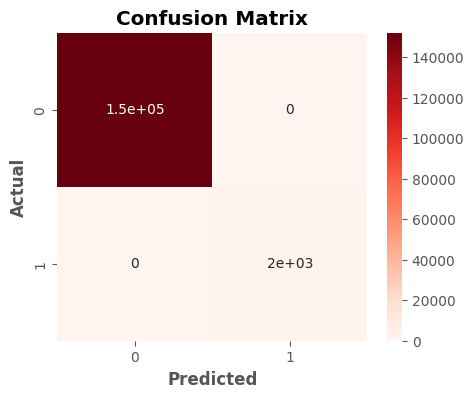

In [43]:
#Model Evaluation
model_evaluation(d_tree, X_test, y_test)

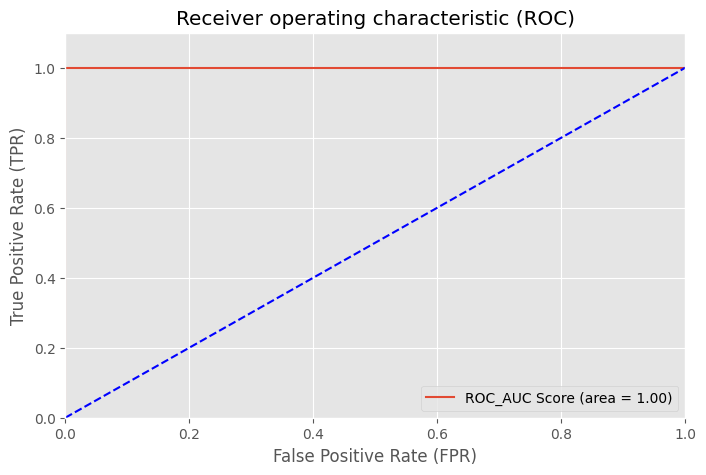

In [44]:
roc_auc_curve_score(d_tree, X_test, y_test)

## Random Forest

In [45]:
# Instantiating Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit the data
rf.fit(X_train_os, y_train_os)

RandomForestClassifier(n_estimators=200, random_state=42)

In [46]:
# Training Accurecy
rf.score(X_train_os, y_train_os)

1.0

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    152119
         1.0       1.00      1.00      1.00      1962

    accuracy                           1.00    154081
   macro avg       1.00      1.00      1.00    154081
weighted avg       1.00      1.00      1.00    154081
 
 


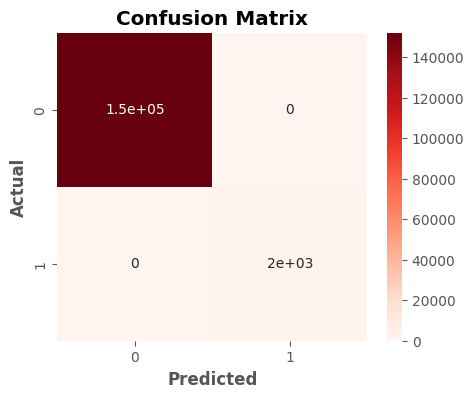

In [48]:
#Model Evaluation
model_evaluation(rf, X_test, y_test)

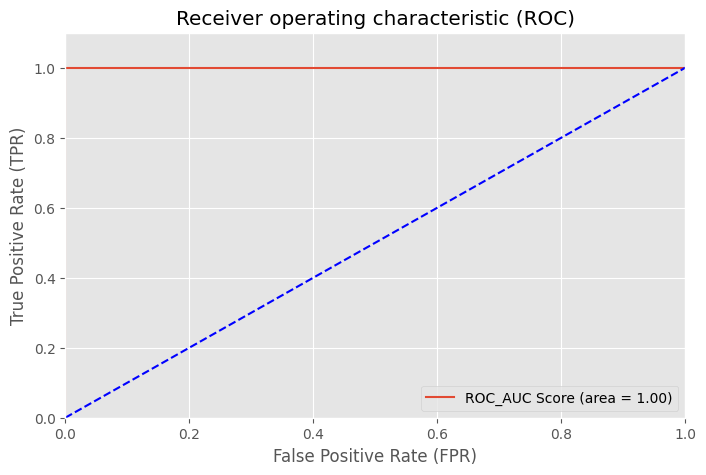

In [49]:
roc_auc_curve_score(rf, X_test, y_test)

## Conclusion
Comparing these three models, we conclude that the Random Forest Classifier model is the best model to be able to detect credit card fraud from our dataset.